In [2]:
import matplotlib.pyplot as plt
import torch
from scipy.special import expi
from math import sqrt, log
from icecream import ic
import numpy as np



# Version Gaussian integral multiplication



Compute the ND gaussian integral kernel of size kernel_size through the formula:

for $x \in \mathbb R^d$ and $\sigma = (\sigma_i)_{i\leq d}$
$$\int_{0}^{k+1} \exp\left(-\frac{1}{2} \left|\frac{2^ux}{\sigma}\right|^2\right) du = \frac{1}{2 \ln(2)}\left[ \mathrm{Ei} \left(-2^{(k+1)/2}\left| \frac{x}{\sigma \sqrt{ 2 }} \right|^2\right) - \mathrm{Ei}\left( - \left| \frac{x}{\sigma \sqrt{ 2 }} \right|^2 \right)  \right]$$

with $|u| = \sum_{i=1}^d |u_{i}|$ (with $|u_{i}|$ applied to scalars being the absolute value)  

In [138]:

def gaussian_integral(sigma, k, kernel_size = None) \
        -> torch.Tensor:
    r"""
    Compute the ND gaussian integral kernel of size kernel_size through the formula:

    for $x \in \mathbb R^d$ and $\sigma = (\sigma_i)_{i\leq d}$
    $$\int_{0}^{k+1} \exp\left(-\frac{1}{2} \left|\frac{2^ux}{\sigma}\right|^2\right) du = \frac{1}{2 \ln(2)}\left[ \mathrm{Ei} \left(-2^{(k+1)/2}\left| \frac{x}{\sigma \sqrt{ 2 }} \right|^2\right) - \mathrm{Ei}\left( - \left| \frac{x}{\sigma \sqrt{ 2 }} \right|^2 \right)  \right]$$

    with $|u| = \sum_{i=1}^d |u_{i}|$ (with $|u_{i}|$ applied to scalars being the absolute value)  

    :param sigma: float, standard deviation of the gaussian kernel
    :param k: int, order of the kernel
    :param kernel_size: int or tuple[int], size of the kernel (optional)

    :return: torch.Tensor, 1D gaussian integral kernel
    """
    def norm(x):
        # return np.abs(x).sum(axis = -1)**2
        return np.sum(x**2,axis = -1)

    if sigma is not np.ndarray:
        sigma = np.array(sigma)

    dx = 1  # pixel size
    if kernel_size is None:
        s = 3 * 2

        kernel_size = [
            max(s, int(sig * s / dx)) + (1 - max(s, int(sig * s / dx)) % 2)
            for sig in sigma
        ]
    arr_list = [
        np.arange(ks, dtype=np.float32) - (ks // 2)
        for ks in kernel_size
    ]
    mesh = tuple(
            list(
                np.meshgrid(*arr_list, indexing='ij')
            )[::-1]  # reverse the order of the list
        )
    x = np.stack(mesh, axis = -1)

    x[x==0] = 1e-6
    Ei_1 = expi(
        -2 ** ((k + 1) / 2) * norm(x / (sigma[None,None] * sqrt(2)))
    )
    Ei_2 =  expi(
        - norm( x / (sigma[None,None] * sqrt(2)) )
    )
    kernel_1d = (Ei_1 - Ei_2) / (2 * log(2) )
    kernel_1d  = torch.tensor(kernel_1d)
    return kernel_1d


torch.Size([25, 31])


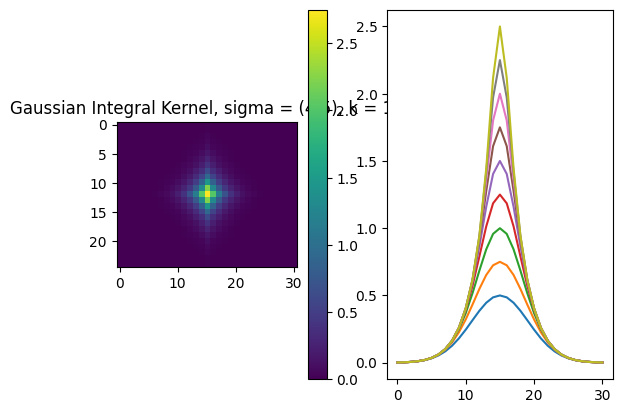

In [4]:

kernel = gaussian_integral([4, 5], 10)
print(kernel.shape)
fig,ax = plt.subplots(1,2)
a = ax[0].imshow(kernel)
ax[0].set_title('Gaussian Integral Kernel, sigma = (4,5), k = 10')
fig.colorbar(a, ax = ax[0])

for k in range(1,10):
    kernel = gaussian_integral((5,5), k)
    h,w = kernel.shape
    ax[1].plot(kernel[h//2], label = f'k = {k}')
plt.show()

In [ ]:
from math import prod
import demeter.utils.reproducing_kernels as rk

class Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS(torch.nn.Module):

    def __init__(self,
                 sigma,
                 k,
                 dx,
                 kernel_size = None,
                 sigma_convention = 'pixel'):
        super(Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS, self).__init__()
        self.dx = dx
        if sigma_convention == 'pixel':
            self.sigma = torch.tensor(sigma)
            self.sigma_continuous = torch.tensor(
                [s*d for d,s in zip(self.dx, sigma)]
            )
        elif sigma_convention == 'continuous':
            self.sigma_continuous = torch.tensor(sigma)
            self.sigma = torch.tensor(
                [s/d for d,s in zip(self.dx, sigma)]
            )
        else:
            raise ValueError("argument sigma_convention must be 'pixel' or 'continuous'"
                             f"got {sigma_convention}")
        self._dim = len(sigma)
        self.k = k
        self.kernel_size = kernel_size
        # if self._dim == 2:
        #     self.kernel = gaussian_integral(sigma, k, kernel_size)
        # else:
        self.kernel = gaussian_integral(self.sigma, k, kernel_size)[None]
        print(self.kernel.min(), self.kernel.max(),(1 - 2**(-self.k))/ ( log(2) * prod(self.sigma) )   ) 
        self.kernel *= (1 - 2**(-self.k))/ ( log(2) * prod(self.sigma))
        
        
        self.filter = rk.fft_filter
        self.kwargs_filter = {'border_type':'constant',
                              }
        
    def init_kernel(self,image):
        if isinstance(self.sigma, tuple) and len(self.sigma) != len(image.shape[2:]) :
            raise ValueError(f"kernelOperator :{self.__class__.__name__}"
                             f"was initialised to be {len(self.sigma)}D"
                             f" with sigma = {self.sigma} and got image "
                             f"source.size() = {image.shape}"
                             )
        self.sigma_continuous = self.sigma_continuous.to(image.device)
        self.sigma = self.sigma.to(image.device)

    def get_all_arguments(self):
        return {
            'name':self.__class__.__name__,
            'sigma':self.sigma,
            'k':self.k,
            'kernel_size':self.kernel_size
        }

    def __repr__(self):
        return (f"{self.__class__.__name__}+\
            (\n\tsigma={self.sigma},"
                f"\n\tsigma_continuous={self.sigma_continuous},"
                f"\n\t k={self.k},"
                f"\n\t dx={self.dx},"
                f"\n\t kernel_size={self.kernel.shape}\n)")

    def forward(self, input):
        """
        Convolve the input tensor with the  kernel.

        Args:
        -------
        input (torch.Tensor):
            the input tensor with shape of :math:`(B, C, H, W)` or :math:`(B, C, D, H, W)`

        Returns:
        -----------
        torch.Tensor: the convolved tensor of same size and numbers of channels as the input.
        """

        if (self._dim == 2 and len(input.shape) == 4) or (self._dim == 3 and len(input.shape) == 5):
            view_sig = (1,-1) + (1,)*(len(input.shape)-2)
            # input *= self.sigma_continuous.to(input.device).view(view_sig)**2
            convol = self.filter(input,self.kernel,**self.kwargs_filter)
            convol *= self.sigma.view(view_sig)**2
            return convol
        else:
            raise ValueError(f"{self.__class__.__name__} was initialized "
                             f"with a {self._dim}D mask and input shape is : "
                             f"{input.shape}")

# Version with erf and E1 function



On utliise gammainc qui est définie comme:
$$P(a, x) = \frac{1}{\Gamma(a)} \int_0^x t^{a - 1}e^{-t} dt$$

(2,)
0 0


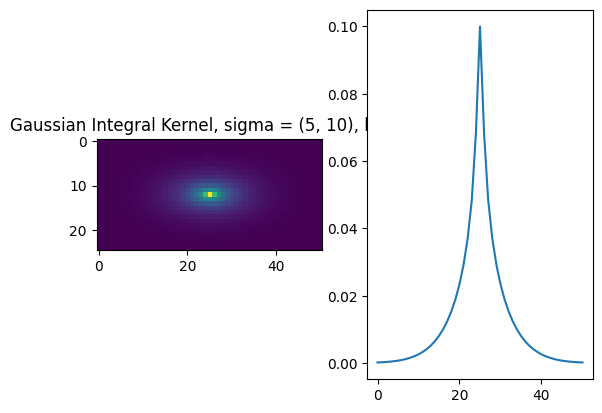

(3,)


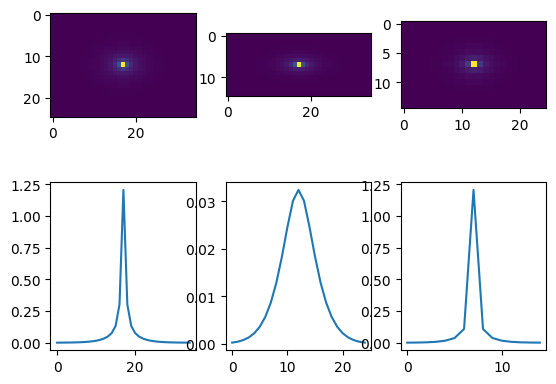

In [25]:
from scipy.special import exp1, erf

def build_x(sigma, kernel_size = None) -> torch.Tensor:
    dx = 1  # pixel size
    if kernel_size is None:
        s = 5
        
        kernel_size = [
            max(s, int(sig * s / dx)) + (1 - max(s, int(sig * s / dx)) % 2)
            for sig in sigma
        ]
    arr_list = [
        np.arange(ks, dtype=np.float32) - (ks // 2)
        for ks in kernel_size
    ]
    mesh = tuple(
        list(
            np.meshgrid(*arr_list, indexing='ij')
         )#[::-1]  # reverse the order of the list
    )
    x = np.stack(mesh, axis = -1)
    
    x[x==0] = 1e-6
    return x

def build_kernel_2d(sigma, k, kernel_size = None) -> torch.Tensor:
    def norm(x):
        # return np.abs(x).sum(axis = -1)**2
        return np.sum(x**2,axis = -1)
    
    if sigma is not np.ndarray:
        sigma = np.array(sigma)
    print(sigma.shape)
    if sigma.shape[0] != 2:
        raise ValueError("sigma must be a 2 elements vector")

    x = build_x(sigma,  kernel_size)
    norm_x = norm(x / sigma[None,None]) / 2
    
    vol = np.prod(sigma)
    exp1_1 = exp1(norm_x)
    exp1_2 = exp1(norm_x * 2**(2 * (k + 1) ))
    print(np.isnan(exp1_1).sum(),np.isnan(exp1_2).sum())
    exp1_diff =  exp1(norm_x) - exp1(norm_x * 2**(2 * (k + 1) ))
    
    return exp1_diff / (2 * log(2) * vol)
   
def build_kernel_3d(sigma, k, kernel_size = None) -> torch.Tensor:
    def norm(x):
        # return np.abs(x).sum(axis = -1)**2
        return np.sqrt(np.sum(x**2,axis = -1))
    
    if sigma is not np.ndarray:
        sigma = np.array(sigma)
    print(sigma.shape)
    if sigma.shape[0] != 3:
        raise ValueError("sigma must be a 3 elements vector")

    x = build_x(sigma,  kernel_size)
    norm_x = norm(x / sigma[None,None]) / sqrt(2)
    
    diff_erf = erf(norm_x * 2**(k + 1)) - erf(norm_x)
    vol = np.prod(sigma)

    return np.sqrt(2 *  np.pi) *  diff_erf / ( log(2) * vol * norm_x) 

sigma = (5,10)
k = 4
kernel_2d = build_kernel_2d(sigma, k)

fig,ax = plt.subplots(1,2)
h,w = kernel_2d.shape
a = ax[0].imshow(kernel_2d)
ax[1].plot(kernel_2d[h//2], label = f'k = {k}')
    
ax[1].plot(kernel_2d[h//2,w//2], label = f'k = {k}')
ax[0].set_title(f'Gaussian Integral Kernel, sigma = {sigma}, k = {k}')
plt.show()


sigma = (3,5,7)
kernel_3d = build_kernel_3d(sigma, k)

fig,ax = plt.subplots(2,3)
h,w,c = kernel_3d.shape
a = ax[0,0].imshow(kernel_3d[h//2])
ax[0,1].imshow(kernel_3d[:,w//2])
ax[0,2].imshow(kernel_3d[:,:,c//2])

ax[1,0].plot(kernel_3d[h//2, w//2], label = f'k = {k}')
ax[1,1].plot(kernel_3d[h//2, :, w//2], label = f'k = {k}')
ax[1,2].plot(kernel_3d[:,w//2, c//2], label = f'k = {k}')
plt.show()


## Build RKHS

On repart de la norme `VolNormalizedGaussianRKHS` . Pour rappel elle est définie comme suit:  
  
Let $\sigma=(\sigma_h)_{1\leq h\leq d}$ be the standard deviation along the different coordinate in $\mathbb R^d$ and $B=B(0,1)$ the closed ball of radius $1$.  We denote $D=\text{diag}(\sigma_h^2)$ and we consider the kernel  
  
$$K_{{AVNG}}(x,y)=\frac{1}{\mathrm{Vol}(D^{1/2} B)}\exp\left(-\frac{1}{2}\langle D^{-1}(x-y),(x-y)\rangle\right)D\,.$$  
call the *anisotropic volume normalized gaussian kernel* (AVNG kernel).

Je propose de noter le nouveau kernel avec le terrible nom : *Multi-Scale Anisotropic Normalized Gaussian (MS-ANG) en attendant de trouver mieux.
Si on note $\kappa = \int_{0}^{k+1} \exp\left(-\frac{1}{2} \left|\frac{2^ux}{\sigma}\right|^2\right) du$ alors on aimerais définir notre nouveau kernel tel que :
$$K_{MS-ANG}(x,y) = \frac{1}{\int_{0}^k \prod_{i=1}^d \frac{\sigma_{i}}{2^u}du} \int_{0}^{k+1} \exp\left(-\frac{1}{2} \langle \frac{2^u}{\sigma}(x-y),(x-y)\rangle\right)du  E  $$
où l'on  et on note 
$$E = \mathrm{diag}\left( \left(\int_{0}^k \frac{\sigma_{h}}{2^u}du \right)^2\right)$$
On peut simplifier $E$ en remarquant que $\int_{0}^k 2^{-u}du =  \frac{1- 2^{-k}}{\ln 2}$ et on as donc $E = \left( \frac{1- 2^{-k}}{\ln 2}   \right)^2 D$  . De même on a :
$$\int_{0}^k \prod_{h=1}^d \frac{\sigma_{h}}{2^u}du = \frac{1- 2^{-k}}{\ln 2} \prod_{i=1}^d \sigma_{h} = \frac{1- 2^{-k}}{\ln 2} \mathrm{Vol}(\sigma) $$
Alors 
$$K_{MS-ANG}(x,y) = \frac{1}{\frac{1- 2^{-k}}{\ln 2} \mathrm{Vol}(D)} \int_{0}^{k+1} \exp\left(-\frac{1}{2} \langle 2^{-u} D^{-1}(x-y),(x-y)\rangle\right)du  \left( \frac{1- 2^{-k}}{\ln 2}   \right)^2 D  $$

Maintenant il s'agit d'exprimer sa discrétisation. De nouveau, je m'appuie sur le document 'meta_on_shere2.pdf', en particulier l'eq. 20. Si on suit le même raisonnement avec $\hat D \dot{=} \Delta^{-2} = \mathrm{diag}\left(\left(  \frac{\sigma_{h}}{\Delta_{h}} \right)^2\right)$ .

$$\hat{K}_{MS-ANG}(x,y) = \frac{1}{ \mathrm{Vol}(D)} \int_{0}^{k+1} \exp\left(-\frac{1}{2} \left\langle  2^{-u}\hat{D}^{-1} (x-y),(x-y) \right\rangle\right)du  \left( \frac{1- 2^{-k}}{\ln 2}   \right) \hat{D}  $$



In [74]:
from math import prod
import demeter.utils.reproducing_kernels as rk

class Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS(torch.nn.Module):

    def __init__(self,
                 sigma,
                 k,
                 dx,
                 kernel_size = None,
                 sigma_convention = 'pixel'):
        super(Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS, self).__init__()
        self.dx = dx
        if sigma_convention == 'pixel':
            self.sigma = torch.tensor(sigma)
            self.sigma_continuous = torch.tensor(
                [s*d for d,s in zip(self.dx, sigma)]
            )
        elif sigma_convention == 'continuous':
            self.sigma_continuous = torch.tensor(sigma)
            self.sigma = torch.tensor(
                [s/d for d,s in zip(self.dx, sigma)]
            )
        else:
            raise ValueError("argument sigma_convention must be 'pixel' or 'continuous'"
                             f"got {sigma_convention}")
        self._dim = len(sigma)
        self.k = k
        self.kernel_size = kernel_size
        # if self._dim == 2:
        #     self.kernel = gaussian_integral(sigma, k, kernel_size)
        # else:
        self.kernel = gaussian_integral(self.sigma, k, kernel_size)[None]
        print(self.kernel.min(), self.kernel.max(),(1 - 2**(-self.k))/ ( log(2) * prod(self.sigma) )   ) 
        self.kernel *= (1 - 2**(-self.k))/ ( log(2) * prod(self.sigma))
        
        
        self.filter = rk.fft_filter
        self.kwargs_filter = {'border_type':'constant',
                              }
        
    def init_kernel(self,image):
        if isinstance(self.sigma, tuple) and len(self.sigma) != len(image.shape[2:]) :
            raise ValueError(f"kernelOperator :{self.__class__.__name__}"
                             f"was initialised to be {len(self.sigma)}D"
                             f" with sigma = {self.sigma} and got image "
                             f"source.size() = {image.shape}"
                             )
        self.sigma_continuous = self.sigma_continuous.to(image.device)
        self.sigma = self.sigma.to(image.device)

    def get_all_arguments(self):
        return {
            'name':self.__class__.__name__,
            'sigma':self.sigma,
            'k':self.k,
            'kernel_size':self.kernel_size
        }

    def __repr__(self):
        return (f"{self.__class__.__name__}+\
            (\n\tsigma={self.sigma},"
                f"\n\tsigma_continuous={self.sigma_continuous},"
                f"\n\t k={self.k},"
                f"\n\t dx={self.dx},"
                f"\n\t kernel_size={self.kernel.shape}\n)")

    def forward(self, input):
        """
        Convolve the input tensor with the  kernel.

        Args:
        -------
        input (torch.Tensor):
            the input tensor with shape of :math:`(B, C, H, W)` or :math:`(B, C, D, H, W)`

        Returns:
        -----------
        torch.Tensor: the convolved tensor of same size and numbers of channels as the input.
        """

        if (self._dim == 2 and len(input.shape) == 4) or (self._dim == 3 and len(input.shape) == 5):
            view_sig = (1,-1) + (1,)*(len(input.shape)-2)
            # input *= self.sigma_continuous.to(input.device).view(view_sig)**2
            convol = self.filter(input,self.kernel,**self.kwargs_filter)
            convol *= self.sigma.view(view_sig)**2
            return convol
        else:
            raise ValueError(f"{self.__class__.__name__} was initialized "
                             f"with a {self._dim}D mask and input shape is : "
                             f"{input.shape}")

# Experiences 

In [28]:
import demeter.utils.torchbox as tb
import demeter.utils.vector_field_to_flow as vff
from demeter.constants import *
import demeter.metamorphosis as mt

def tp(x):
    """ prepare simplex tensor to be plotted as an image
    
    """
    tp_img = x[0].permute(1,2,0).cpu().numpy()
    if tp_img.shape[-1] in [3,4]:
        return tp_img
    elif tp_img.shape[-1] == 2:
        z_shape = tp_img.shape[:-1]
        zero = np.zeros(z_shape + (1,))
        return np.concatenate(
            [tp_img,zero],axis=-1
        )
    
def to_plot(img):
    if img.shape[-1] == 3:
        return img
    elif img.shape[-1] == 4:
        return img[...,:-1]

def make_exp(xxx, yyy, centre, sigma):
    ce_x, ce_y = centre
    sigma_x,sigma_y = sigma
    exp = torch.exp(
        - 0.5*((xxx - ce_x) / sigma_x) ** 2
        - 0.5*((yyy - ce_y) / sigma_y) ** 2)
    return exp


## Residual métric
        
def get_deformator(mp,from_t=0,to_t=None,save=False):
    temporal_integrator = vff.FieldIntegrator(method='temporal',save=save)
    if from_t is None and to_t is None:
        print('Je suis passé par là')
        return temporal_integrator(mp.field_stock/mp.n_step, forward=False)
    # if from_t is None: from_t = 0
    if to_t is None: to_t = mp.n_step 
    if from_t < 0 and from_t >= to_t: 
        raise ValueError(f"from_t must in [0,n_step-1], got from_t ={from_t} and n_step = {mp.n_step}")
    if to_t > mp.n_step: 
        raise ValueError(f"to_t must in [from_t+1,n_step], got to_t ={to_t} and n_step = {mp.n_step}")
    if to_t==1:
        return mp.id_grid.detach().cpu() - mp.field_stock[0][None].detach().cpu() / mp.n_step
    # ic(from_t,to_t,mp.field_stock[from_t:to_t].shape)
    return temporal_integrator(mp.field_stock[from_t:to_t]/mp.n_step, forward=False)
    
# Plot visu registration:
def get_resi_cumul_onTarget(mr, debug = False ) :
    resi_sum = torch.zeros_like(mr.target)
    N = mr.mp.residuals_stock.shape[0]
    if debug:
        fig,ax = plt.subplots(2,N,figsize=(5*N,10),constrained_layout=True)
    
    for i in range(N):
        deform_t = get_deformator(mr.mp,from_t=i,save=False)
        # ic(mr.mp.residuals_stock[i].min(),mr.mp.residuals_stock[i].max())
        resi_sum += sqrt(1 - mr._get_rho_()) * tb.imgDeform(mr.mp.residuals_stock[i][None], deform_t,dx_convention=mr.dx_convention) / mr.mp.n_step
        # ic(resi_sum.min(),resi_sum.max())
        if debug:
            to_show_r = resi_sum.squeeze().permute(1,2,0).numpy()
            ax[0,i].imshow(to_show_r[...,:-1])
            ax[1,i].imshow(mr.mp.residuals_stock[i].squeeze().permute(1,2,0).numpy()[...,:-1])
            set_ticks_off(ax)
    return resi_sum    
    
def residual_quality_metric(mr,resi_rhoInfty):
    resi_sum = get_resi_cumul_onTarget(mr,debug=False)
    return torch.sum((resi_sum - resi_rhoInfty ) ** 2)
    
def plot_endresult(mr,save=False, return_all=False,filename=None):
    image_ts = tp(mr.mp.image) **2
    # momentum_ts = mr.mp.momentum.permute(0,2,3,1).squeeze().cpu().detach().numpy()
    momentum_ts = tp(mr.mp.momentum)    
    
    # ic(image_ts.shape)
    residual_cumul = get_resi_cumul_onTarget(mr,debug=False)#.cpu().permute(0,2,3,1)[0]
    # print('residual_cumul.shape:',residual_cumul.shape)
    # residual_cumul = residual_cumul.sum(dim=-1)
    # residual_cumul = residual_cumul
    #residual_ts = mr.mp.residuals.squeeze().permute(1,2,0).numpy() 
    
    deform = mr.mp.get_deformation()
    # print("source dtype",source.dtype)
    # print("deformator",mr.mp.get_deformator().dtype)
    im_deformed_only = tb.imgDeform(source.to('cpu'),mr.mp.get_deformator().cpu(),dx_convention=mr.dx_convention)
    im_deformed_only = tp(im_deformed_only) 
    
    diff_im_t = np.sum(np.abs(image_ts-tp(target)),axis=-1)
    diff_im_def = np.sum(np.abs(im_deformed_only-tp(target)),axis=-1)

    metric_ssd = np.sqrt(np.sum((image_ts-tp(target))**2))
    metric_sdd_def_only = np.sqrt(np.sum((im_deformed_only-tp(target))**2))

    fig,ax = plt.subplots(3,3,figsize=(10,10),constrained_layout=True)
    fig.suptitle(mr.mp, fontsize=16)
    ax[0,0].imshow(tp(source))
    ax[0,0].set_title("Source")
    ax[0,1].imshow(tp(target))
    ax[0,1].set_title("Target")
    
    step = max(1,deform.shape[1]//15)
    tb.gridDef_plot_2d(deform,step=step,ax=ax[0,2],check_diffeo=False,origin = 'upper')
    
    
    ax[1,1].imshow(image_ts)
    ax[1,1].set_title("Image")
    ax[1,0].imshow(momentum_ts)
    ax[1,0].set_title("Momentum")
    # ic(residual_cumul.shape)
    # ic(residual_cumul.dtype)
    d = ax[1,2].imshow(tp(residual_cumul))
    fig.colorbar(d, ax=ax[1,2])
    ax[1,2].set_title("Cumulative residual")
    
    ax[2,0].imshow(im_deformed_only)
    ax[2,0].set_title(f"only Deformed Source")
    d = ax[2,1].imshow(diff_im_t,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,1])
    ax[2,1].set_title(f"Diff Image Target = {metric_ssd:.2f}")
    d = ax[2,2].imshow(diff_im_def,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,2])
    ax[2,2].set_title(f"Diff Image only deformed m = {metric_sdd_def_only:.2f}")
    
    
    set_ticks_off(ax)
    if save:
        if filename is None:
            filename = f"{path_save}{name}_{mr.mp.kernelOperator.sigma_continuous.tolist()}_summary.png"
        else:
            filename = f"{path_save}{filename}.png"
        plt.savefig(filename)
    
    if return_all:
        return {"metric_ssd" : metric_ssd,
                "metric_sdd_def_only" : metric_sdd_def_only,
                "im_deformed_only" : im_deformed_only,
                "image_ts" : image_ts,
                "momentum_ts" : momentum_ts,
                "residual_cumul" : residual_cumul
                }
    else:
        return metric_ssd,metric_sdd_def_only
    
device = 'cuda:0'


def experience_3(size,sigma):
    H,W = size
   
    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]
   
    def th(u):
        return (1.0+(30.0*u).tanh())/2.
   
    ## Background simplex
    image = torch.zeros((1,2,H,W))
    image[0,0] = (xx >= .5)
    image[0,1] = (xx <.5)
    #image[0,0] = th(xx - .5)
    #image[0,1] = th(.5-  xx)
    print(image.max())
   
    moving = image.clone()
   
    # add exps
    sigma_exp1 = (0.3*sigma,0.3*sigma)
    sigma_exp2 = (2*sigma,sigma)
    exp = make_exp(xx,yy,(.5,.3),sigma_exp2)
    exp += make_exp(xx,yy,(.5,.7),sigma_exp1)
   
    image[0,1] = (xx-0.3*(1-yy)*(40*yy**2).sin())<.5
    image[0,0] =1 - image[0,1]
    fixed = image.clone()
    name = 'add_vol_sigma'
    return moving,fixed, name


saves_overview.csv


### Open images

tensor(1.)


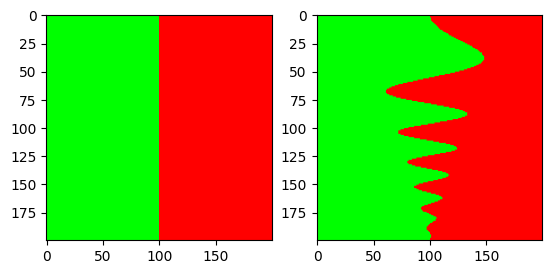

In [29]:

source,target, name = experience_3((200,200),.08)
name = "all_scale_norm"
path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
if not os.path.exists(path_save):
    os.makedirs(path_save)
    
fig,ax = plt.subplots(1,2)
ax[0].imshow(tp(source))
ax[1].imshow(tp(target))
# ax[2].imshow((boule - newboule)[0,0])
plt.show()

# 2. Registrations with differents RKHS

## 2.1 Simple Gaussian Kernel

In this example, we focus on registering the better we can the biggest bump.

GaussianRKHS,2D 
	filter :fft_filter, sigma :(21.459660262893472, 21.459660262893472)
	kernel_size :(1, 257, 257)
	kernel_reach :6
	normalized :False
kernel shape: torch.Size([1, 257, 257])
kernel shape: 257 257
x, y torch.Size([257, 257]) torch.Size([257, 257])


/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


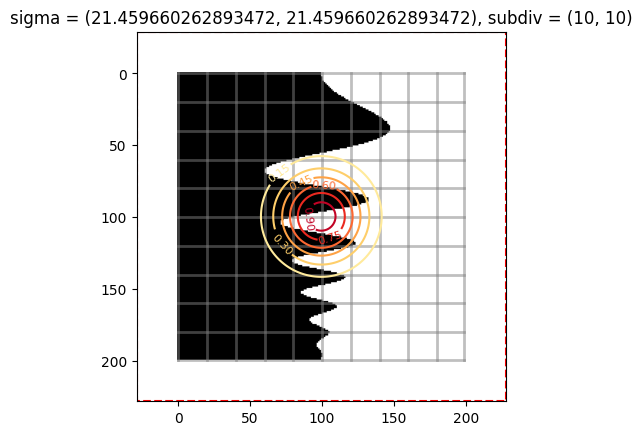

<Axes: title={'center': 'sigma = (21.459660262893472, 21.459660262893472), subdiv = (10, 10)'}>

In [32]:
subdiv = (10,10)
dx_convention = 'pixel' 
sigma = rk.get_sigma_from_img_ratio(source.shape,subdiv)

kernelOperator = rk.GaussianRKHS(sigma,
                                 # kernel_reach= 4,
                                 normalized=False,
                                 dx_convention = dx_convention
                                 )
print(kernelOperator)

rk.plot_kernel_on_image(kernelOperator,
                     subdiv = subdiv,
                     image = target,
                     # image_shape = (1,1,120,120)
                        )

Progress: [##########] 100.00% Done... ,1402.8734).
 (Ssd : ,1404.9344).
Computation of forward done in  0:00:35s and 0.223cents  s


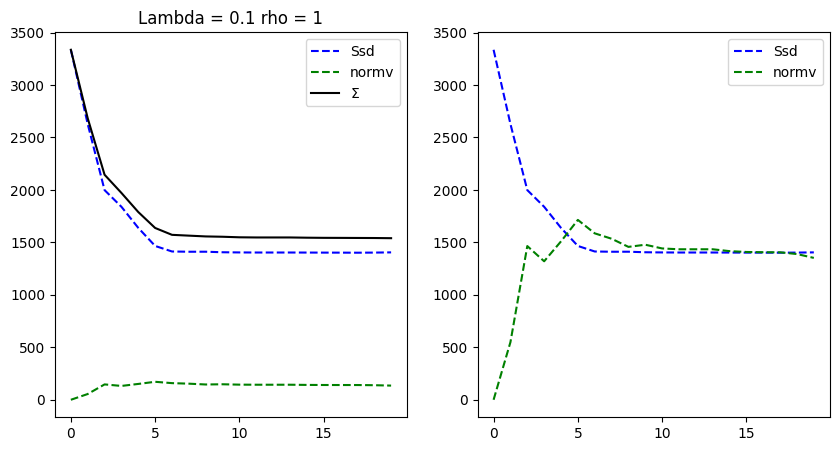

In [52]:
source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)

rho = 1

momentum_ini = torch.zeros_like(source)
# momentum_ini = mr.to_analyse[0].to('cuda')
momentum_ini.requires_grad = True
# data_cost = mt.Ssd_normalized(target)
data_cost =  None
ic.disable()

mr = mt.simplex_metamorphosis(source.clone(),target.clone(),momentum_ini,kernelOperator,rho,
                               n_step=10,
                               n_iter=20,
                               grad_coef=.2,
                               cost_cst=.1,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = False,
                              ham = False
    )
fig_cost,_ =mr.plot_cost()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3533774161542635..2.205142075807658].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001192092896].


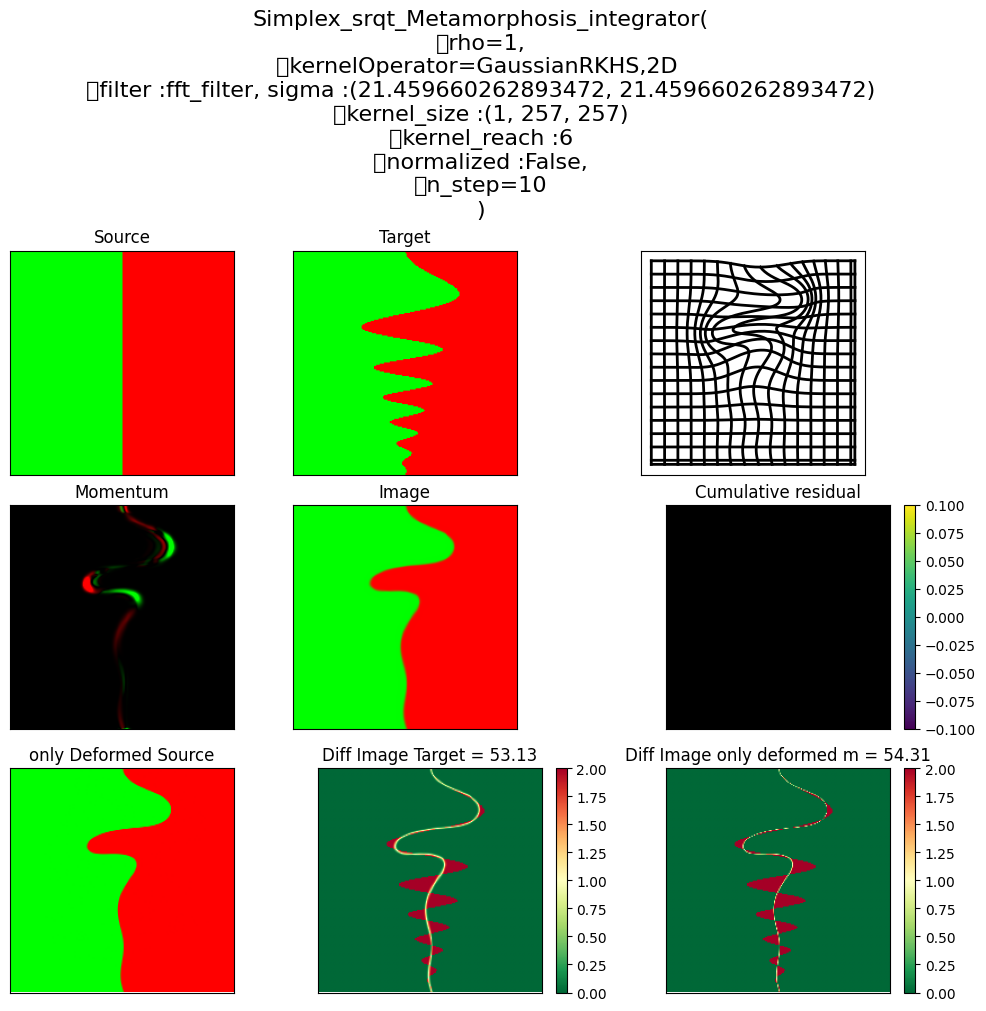

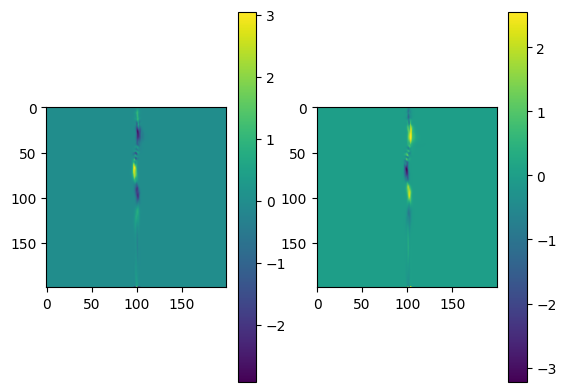

In [53]:
mr.to_device('cpu')
end_result = plot_endresult(mr,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

fig,ax = plt.subplots(1,2)
a = ax[0].imshow(mr.mp.momentum_stock[0,0].detach().cpu())
fig.colorbar(a, ax=ax[0])
b =ax[1].imshow(mr.mp.momentum_stock[0,1].detach().cpu())
fig.colorbar(b, ax=ax[1])
plt.show()

## 2.2 Vol Normalised Gaussian Kernel 

with the same poorly choosen sigma



In [55]:
## New VolNormalizedGaussianRKHS version
data_cost = mt.Ssd_normalized(target)
dx = tuple([1./(s-1) for s in source.shape[2:]])
# dx = (1,1)
print(dx)
# s=0.07
# sigma = (s,s)
# sigma = (3,9)
kernelOperator = rk.VolNormalizedGaussianRKHS(
        sigma=sigma,
        sigma_convention='pixel', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        dx=dx,
        border_type='constant'
    )

(0.005025125628140704, 0.005025125628140704)


Progress: [##########] 100.00% Done...ormalized : ,  0.0507).
 (Ssd_normalized : ,  0.0507).
Computation of forward done in  0:27:22s and 0.906cents  s


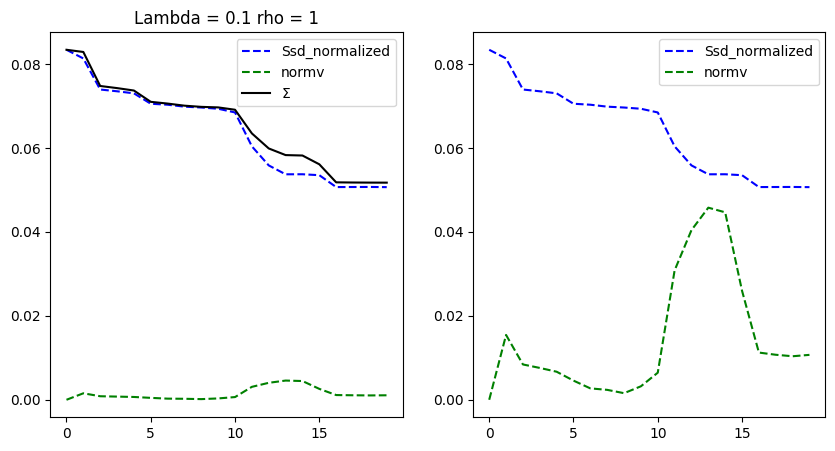

In [56]:
source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)

rho = 1

momentum_ini = torch.zeros_like(source)
# momentum_ini = mr.to_analyse[0].to('cuda')
momentum_ini.requires_grad = True
data_cost = mt.Ssd_normalized(target)
# data_cost =  None
ic.disable()

mr = mt.simplex_metamorphosis(source,target,momentum_ini,kernelOperator,rho,
                               n_step=10,
                               n_iter=20,
                               grad_coef=.2,
                               cost_cst=.1,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = False,
                              ham = False
    )
fig_cost,_ =mr.plot_cost()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1616427560924005..0.1572600141612074].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001192092896].


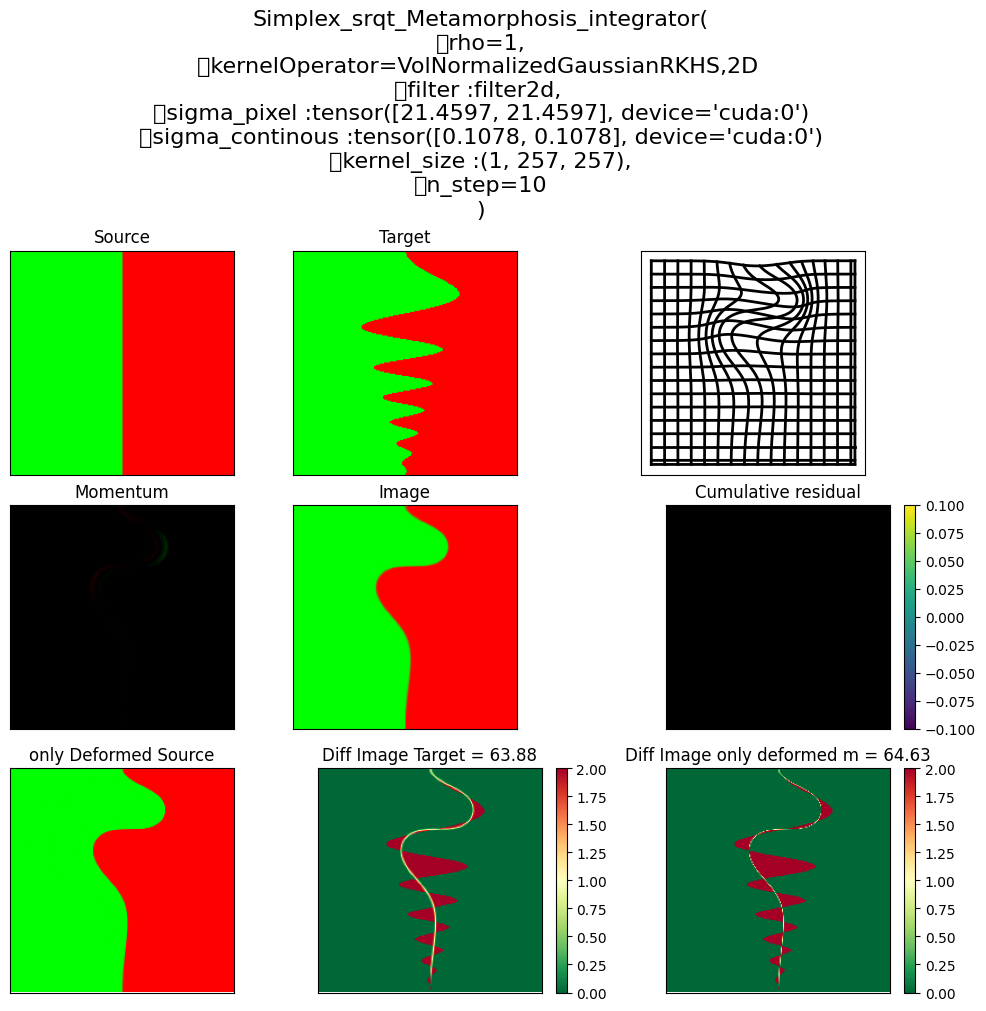

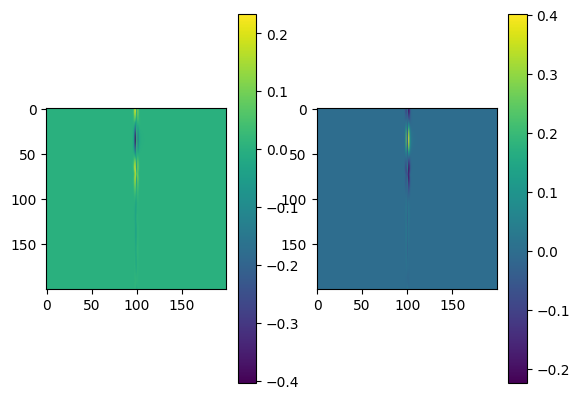

In [57]:
mr.to_device('cpu')
end_result = plot_endresult(mr,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

fig,ax = plt.subplots(1,2)
a = ax[0].imshow(mr.mp.momentum_stock[0,0].detach().cpu())
fig.colorbar(a, ax=ax[0])
b =ax[1].imshow(mr.mp.momentum_stock[0,1].detach().cpu())
fig.colorbar(b, ax=ax[1])
plt.show()

## 2.3  All scale Normalized Gaussian Kernel

with the same poorly choosen sigma

In [38]:
from math import prod
import demeter.utils.reproducing_kernels as rk


class Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS(torch.nn.Module):

    def __init__(self,
                 sigma,
                 k,
                 dx,
                 kernel_size = None,
                 sigma_convention = 'pixel'
                 ):
        super(Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS, self).__init__()
        self.dx = dx
        if sigma_convention == 'pixel':
            self.sigma = torch.tensor(sigma)
            self.sigma_continuous = torch.tensor(
                [s*d for d,s in zip(self.dx, sigma)]
            )
        elif sigma_convention == 'continuous':
            self.sigma_continuous = torch.tensor(sigma)
            self.sigma = torch.tensor(
                [s/d for d,s in zip(self.dx, sigma)]
            )
        else:
            raise ValueError("argument sigma_convention must be 'pixel' or 'continuous'"
                             f"got {sigma_convention}")
        self._dim = len(sigma)
        self.k = k
        self.kernel_size = kernel_size
        if self._dim == 2:
            self.kernel = torch.Tensor(build_kernel_2d(sigma, k, kernel_size))[None]
        elif self._dim == 3:
            self.kernel = torch.Tensor(build_kernel_3d(sigma, k, kernel_size))[None]
        else:
            raise NotImplementedError("Only 2D and 3D are supported")
        
        self.filter = rk.fft_filter
        self.kwargs_filter = {'border_type':'constant',
                              }
        
    def init_kernel(self,image):
        if isinstance(self.sigma, tuple) and len(self.sigma) != len(image.shape[2:]) :
            raise ValueError(f"kernelOperator :{self.__class__.__name__}"
                             f"was initialised to be {len(self.sigma)}D"
                             f" with sigma = {self.sigma} and got image "
                             f"source.size() = {image.shape}"
                             )
        self.sigma_continuous = self.sigma_continuous.to(image.device)
        self.sigma = self.sigma.to(image.device)

    def get_all_arguments(self):
        return {
            'name':self.__class__.__name__,
            'sigma':self.sigma,
            'k':self.k,
            'kernel_size':self.kernel_size
        }

    def __repr__(self):
        return (f"{self.__class__.__name__}+\
            (\n\tsigma={self.sigma},"
                f"\n\tsigma_continuous={self.sigma_continuous},"
                f"\n\t k={self.k},"
                f"\n\t dx={self.dx},"
                f"\n\t kernel_size={self.kernel.shape}\n)")

    def forward(self, input):
        """
        Convolve the input tensor with the  kernel.

        Args:
        -------
        input (torch.Tensor):
            the input tensor with shape of :math:`(B, C, H, W)` or :math:`(B, C, D, H, W)`

        Returns:
        -----------
        torch.Tensor: the convolved tensor of same size and numbers of channels as the input.
        """

        if (self._dim == 2 and len(input.shape) == 4) or (self._dim == 3 and len(input.shape) == 5):
            view_sig = (1,-1) + (1,)*(len(input.shape)-2)
            # input *= self.sigma_continuous.to(input.device).view(view_sig)**2
            convol = self.filter(input,self.kernel,**self.kwargs_filter)
            convol *= self.sigma.view(view_sig)**2
            return convol
        else:
            raise ValueError(f"{self.__class__.__name__} was initialized "
                             f"with a {self._dim}D mask and input shape is : "
                             f"{input.shape}")

(0.005025125628140704, 0.005025125628140704)
(2,)
0 0
Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([21.4597, 21.4597]),
	sigma_continuous=tensor([0.1078, 0.1078]),
	 k=10,
	 dx=(0.005025125628140704, 0.005025125628140704),
	 kernel_size=torch.Size([1, 107, 107])
)
image min max tensor(-0.0004) tensor(2078.0249)


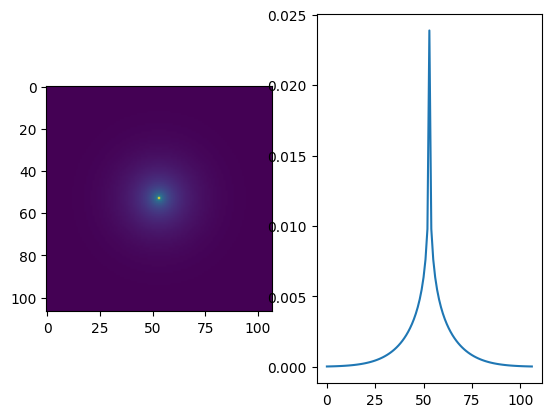

In [39]:
data_cost = mt.Ssd_normalized(target)
dx = tuple([1./(s-1) for s in source.shape[2:]])
# dx = (1,1)
print(dx)
# s=0.07
# sigma = (s,s)
# sigma = (3,9)
kernelOperator = Multi_Scale_Anisotropic_Normalized_Gaussian_RKHS(
        sigma=sigma,
        sigma_convention='pixel', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        k = 10,
        dx=dx,
    )
print(kernelOperator)

image = kernelOperator(source.cpu())
print("image min max",image.min(), image.max())

kernel  = kernelOperator.kernel[0].cpu()
h,w  = kernel.shape
fig,ax = plt.subplots(1,2)
ax[0].imshow(kernel)
ax[1].plot(kernel[h//2])
plt.show()


In [87]:
(1 - 2**(-10))/log(2)

1.4412861590130954

0.9999
Progress: [##########] 100.00% Done...ormalized : ,  0.0022).
 (Ssd_normalized : ,  0.0022).
Computation of forward done in  0:01:09s and 0.739cents  s


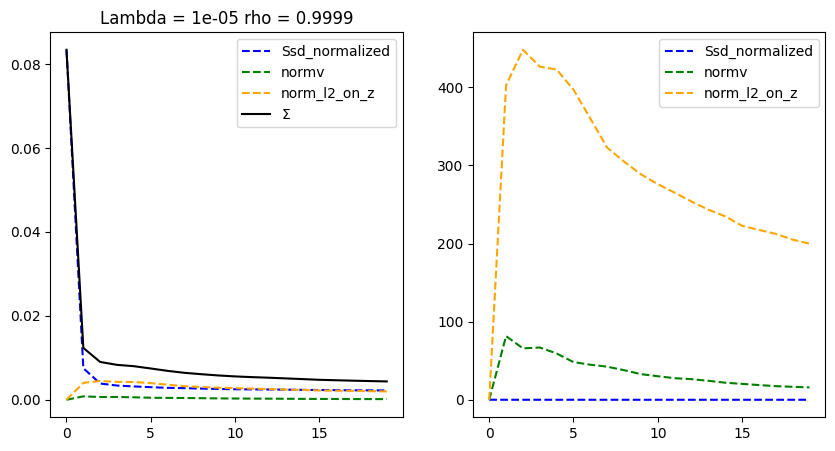

In [62]:
source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)

rho = 1
rho = 1 - 1e-4
print(rho)

momentum_ini = torch.zeros_like(source)
# momentum_ini = mr.to_analyse[0].to('cuda')
momentum_ini.requires_grad = True
data_cost = mt.Ssd_normalized(target)
# data_cost =  None
ic.disable()

mr = mt.simplex_metamorphosis(source,target,momentum_ini,kernelOperator,rho,
                               n_step=20,
                               n_iter=20,
                               grad_coef=2,
                               cost_cst=.00001,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = False,
                              ham = False
    )
fig_cost,_ =mr.plot_cost()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1151892069531875..1.0293431832627191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021879035979509354..0.016650833189487457].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001192092896].


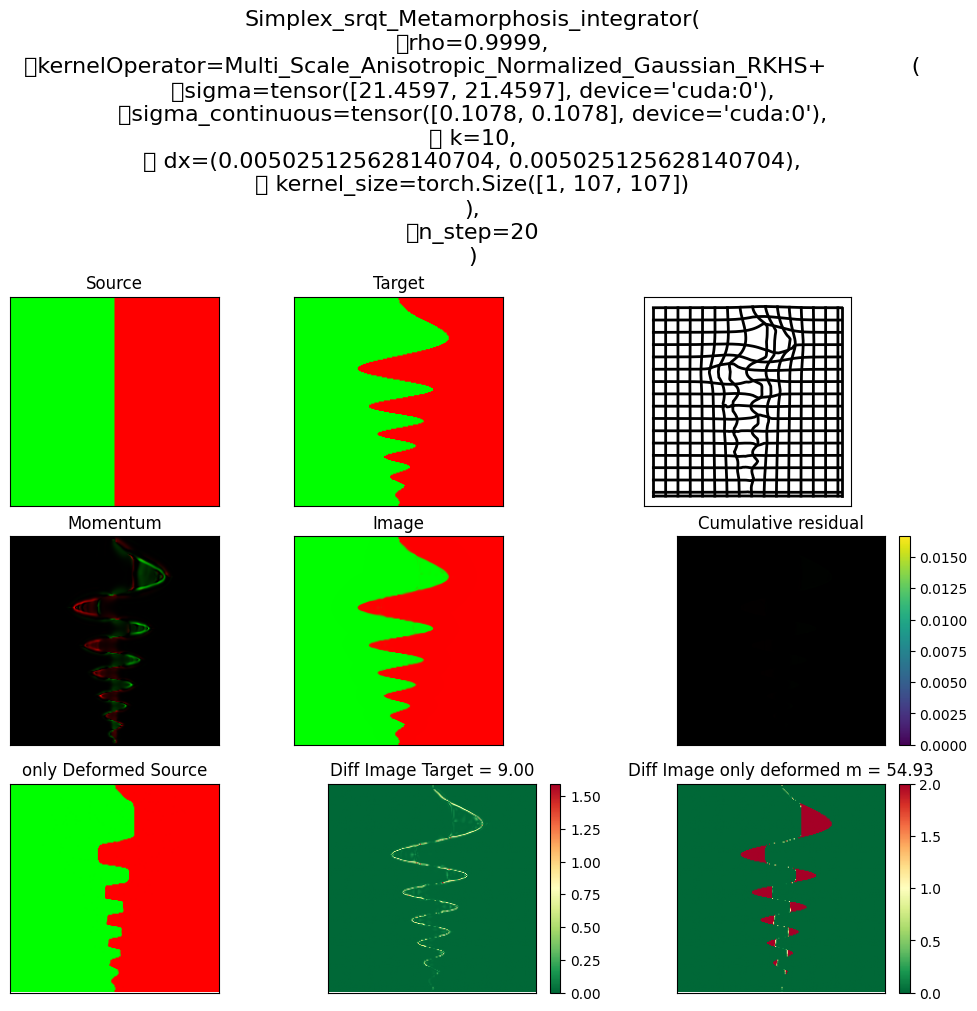

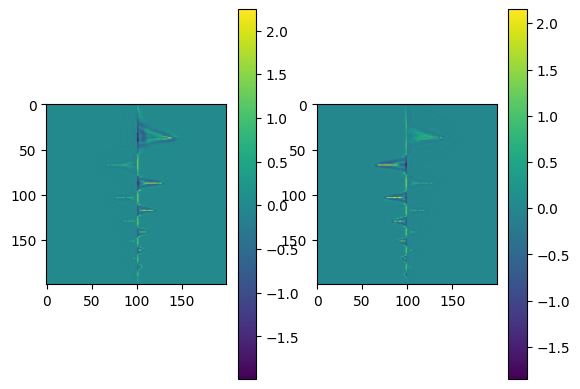

In [63]:
mr.to_device('cpu')
end_result = plot_endresult(mr,save=False, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")

fig,ax = plt.subplots(1,2)
a = ax[0].imshow(mr.mp.momentum_stock[0,0].detach().cpu())
fig.colorbar(a, ax=ax[0])
b =ax[1].imshow(mr.mp.momentum_stock[0,1].detach().cpu())
fig.colorbar(b, ax=ax[1])
plt.show()

/tmp/ipykernel_102627/1943387269.py:4: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(deform,step=1,ax= ax,check_diffeo=True, color='black')
/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


(<Axes: title={'center': 'diffeo = tensor(False)'}>,
  <matplotlib.lines.Line2D at 0x75fa2276b9b0>])

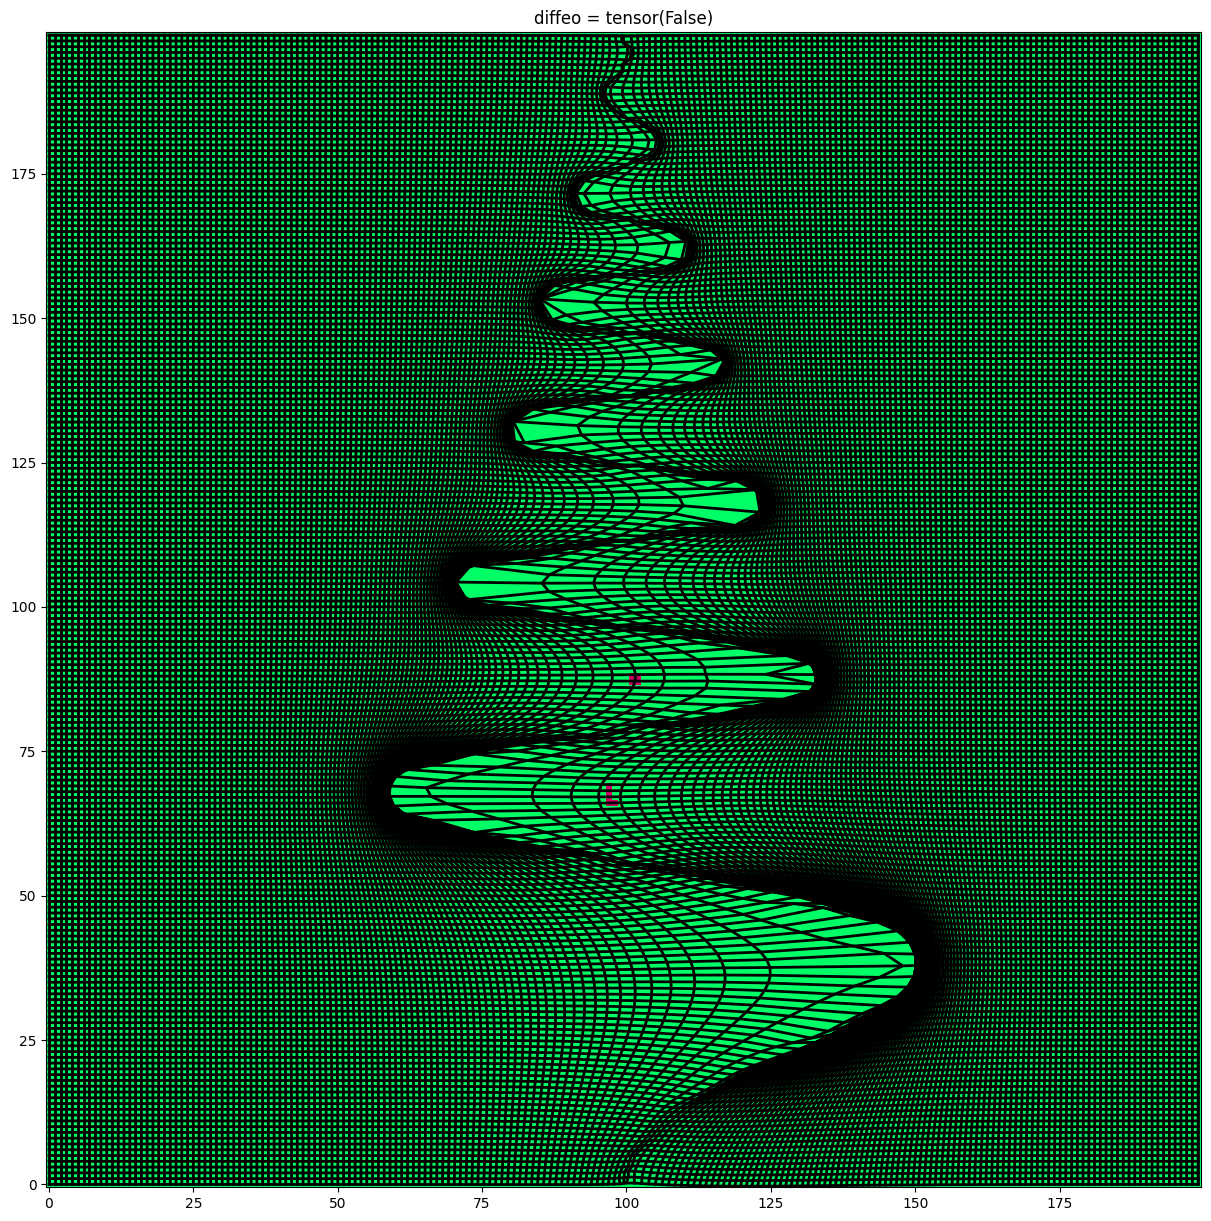

In [42]:
deform =  mr.mp.get_deformation()

fig, ax = plt.subplots(1,1, figsize=(15,15))
tb.gridDef_plot(deform,step=1,ax= ax,check_diffeo=True, color='black')